In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn as nn
import torch.optim as optim
import os,sys
import random
from skimage.transform import resize
import models
sys.path.insert(0,'/home/huangz78/hydro/unet3d/')
import torch.fft as F
from models.unet3d_model import UNet3D, ResidualUNet3D 
from models.dnet import weights_init, Discriminator
import utils
from utils import *
# from train import gan_train,noise_generate
from importlib import reload
from scipy.interpolate import griddata

from torch.autograd import Variable
import copy

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
reload(utils)
from utils import *

# track adversial training errors

In [2]:
errorRec_path = '/mnt/DataA/checkpoints/leo/hydro/wgan_train_track_wg_Abel-gaussian_scaling_1.0_supwegt0_supweigtdecay_1_masswegt_0_d_1_g_4_gradpen_1.npz'
errordata = np.load(errorRec_path)
%matplotlib notebook
%matplotlib inline
print(errordata.files)

['g_loss', 'd_loss', 'Massdiffs', 'nrmse_train', 'l1_train', 'nrmse_val', 'l1_val', 'bce_real', 'bce_fake']


In [ ]:
np.argmin(errordata['nrmse_val'])

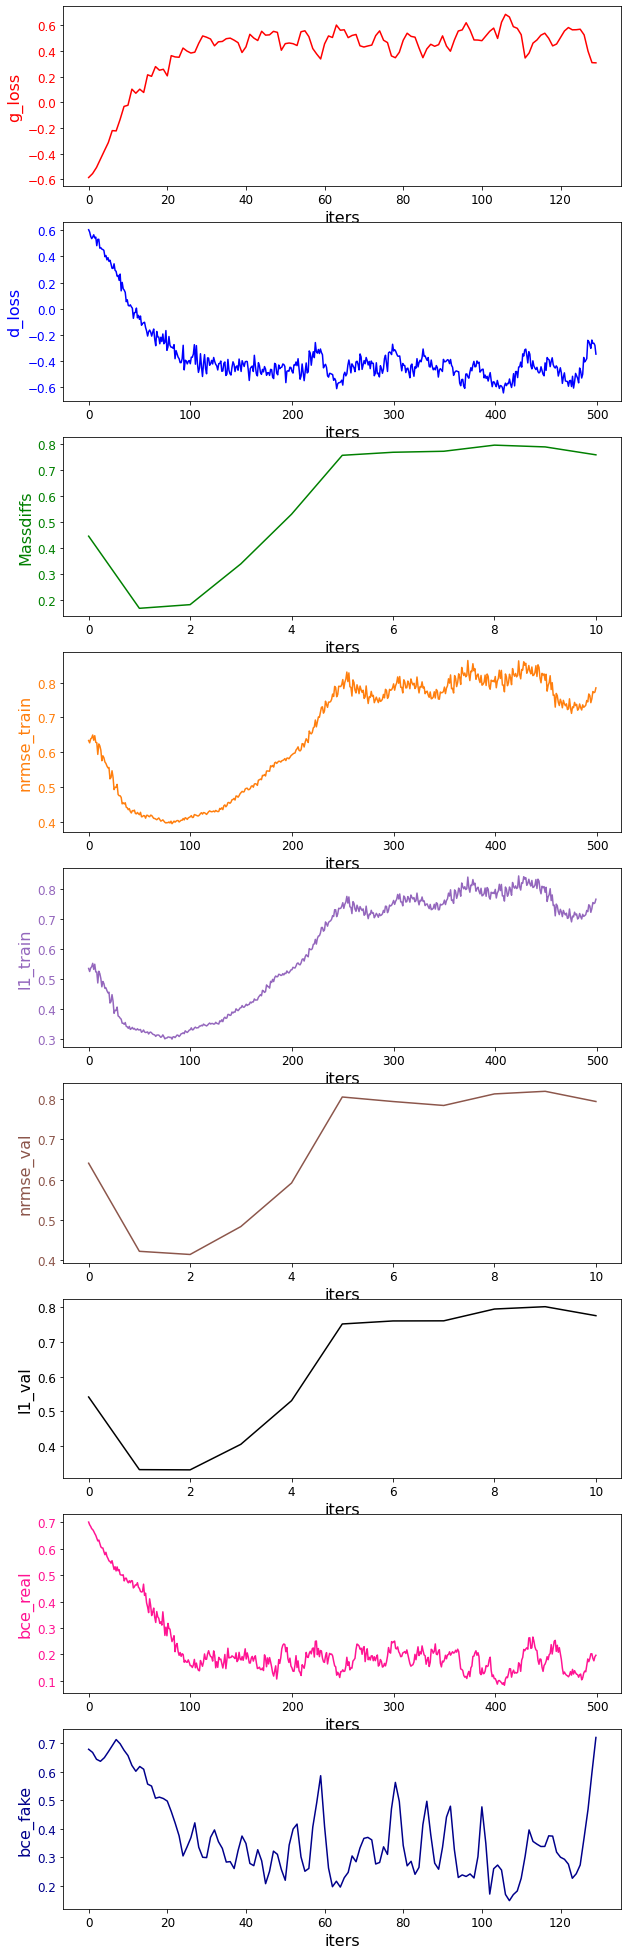

In [3]:
visualization(errordata,errordata.files,log=False,figsize=(10,35))

# running tests

In [2]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

datapath = '/mnt/DataB/hydro_simulations/data/'

ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
traintotal = 1000
valtotal   = 100
testtotal  = 100
print('Total amount of available files:', len(ncfiles))
print('Train file amount: {}'.format(traintotal))
print('Val   file amount: {}'.format(valtotal))
print('Test  file amount: {}'.format(testtotal))

trainfiles = random.sample(set(ncfiles),k=traintotal)
ncfiles = set(ncfiles) - set(trainfiles)
valfiles  = random.sample(ncfiles,k=valtotal)
ncfiles = set(ncfiles) - set(valfiles)
testfiles = random.sample(ncfiles,k=testtotal)
# np.savez('/mnt/DataA/checkpoints/leo/hydro/' +f'filesUsed.npz',\
#                  trainfiles=trainfiles,valfiles=valfiles,testfiles=testfiles)

Random Seed:  999
Total amount of available files: 13798
Train file amount: 1000
Val   file amount: 100
Test  file amount: 100


/tmp/ipykernel_2299027/1914025074.py:20: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  trainfiles = random.sample(set(ncfiles),k=traintotal)
/tmp/ipykernel_2299027/1914025074.py:22: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  valfiles  = random.sample(ncfiles,k=valtotal)
/tmp/ipykernel_2299027/1914025074.py:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  testfiles = random.sample(ncfiles,k=testtotal)


In [6]:
# load a G net
noise_mode = 'Abel-gaussian'
gnet = ResidualUNet3D(1,1,num_levels=4,is_segmentation=False,final_sigmoid=False)
gpath = f'/mnt/DataA/checkpoints/leo/hydro/netG_wg_{noise_mode}_scaling_1_supwegt0.99_supweigtdecay_0.97_masswegt_10_d_1_g_1_gradpen_10_epoch9_.pt'
checkpoint = torch.load(gpath)
gnet.load_state_dict(checkpoint['model_state_dict'],strict=True)
gnet.eval()
print(f' G net is successfully loaded from {gpath}! ')
gnet_params_num = gnet.n_params
print('total amount of parameters in gnet: ', gnet_params_num)


### running a single test
noise_mode = 'Abel-gaussian'
scaling    = 1
supwgt     = .97
batchsize  = 5

maxIter    = 1e3
postprocess = False
device = torch.device('cuda:0')
# device = torch.device('cpu')

massdiff, nrmse, nl1err = test_(gnet,testfiles,batchsize=batchsize,noise_mode=noise_mode,scaling=scaling,\
      device=device,postprocess=postprocess,maxIter=maxIter)
# dir_rec = f'/home/leo/hydro/hist_{noise_mode}_{scaling}_supwgt{supwgt}_post_{postprocess}.npz'
# np.savez(dir_rec,massdiff=massdiff,nrmse=nrmse,nl1err=nl1err)
print(f'test result saved for noise mode {noise_mode}, scaling {scaling}, supwgt {supwgt}')

[5/100]
[10/100]
[15/100]
[20/100]
[25/100]
[30/100]
[35/100]
[40/100]
[45/100]
[50/100]
[55/100]
[60/100]
[65/100]
[70/100]
[75/100]
[80/100]
[85/100]
[90/100]
[95/100]
[100/100]
test result saved for noise mode Abel-gaussian, scaling 1, supwgt 0.97


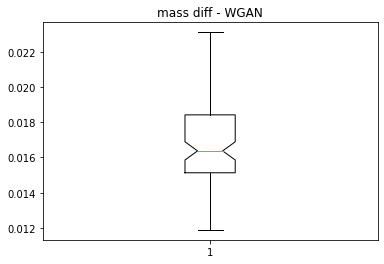

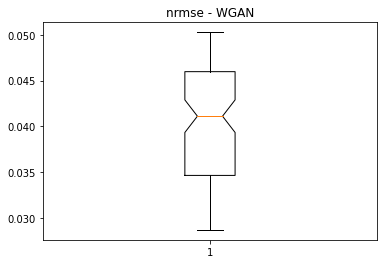

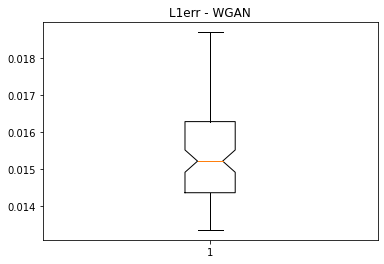

In [9]:
plt.figure()
plt.title('mass diff - WGAN')
plt.boxplot(massdiff,notch=True)
plt.show()

plt.figure()
plt.title('nrmse - WGAN')
plt.boxplot(nrmse,notch=True)
plt.show()

plt.figure()
plt.title('L1err - WGAN')
plt.boxplot(nl1err,notch=True)
plt.show()

In [ ]:
### running multiple tests
noise_mode   = 'Abel-gaussian'
# noise_mode   = 'Abel-gaussian-double'
# scaling_grid = 10**np.array([-4, -3, -2, -1, 0.5, 0.66, 0.82, 1, 1.16])
scaling_grid = 10**np.array([ -1.])
supwgt       = .97
batchsize    = 5

maxIter      = 1e3
postprocess  = False
device       = torch.device('cuda:0')
# device       = torch.device('cpu')

In [ ]:
# load a G net
gnet = ResidualUNet3D(1,1,num_levels=4,is_segmentation=False,final_sigmoid=False)
gpath = f'/mnt/DataA/checkpoints/leo/hydro/netG_sup_{noise_mode}_scaling_1_masswegt_10_epoch9_.pt'
checkpoint = torch.load(gpath)
gnet.load_state_dict(checkpoint['model_state_dict'],strict=True)
gnet.eval()
print(f' G net is successfully loaded from {gpath}! ')
gnet_params_num = gnet.n_params
print('total amount of parameters in gnet: ', gnet_params_num)

massdiff_sup_dict = {}
nrmse_sup_dict    = {}
nl1err_sup_dict   = {}
for scaling in scaling_grid:
    massdiff, nrmse, nl1err = test_(gnet,testfiles,batchsize=batchsize,noise_mode=noise_mode,scaling=scaling,\
      device=device,postprocess=postprocess,maxIter=maxIter,weight_datafid=5)
    massdiff_sup_dict[str(scaling)] = massdiff
    nrmse_sup_dict[str(scaling)]    = nrmse
    nl1err_sup_dict[str(scaling)]   = nl1err
# dir_rec = f'/home/leo/hydro/hist_{noise_mode}_{scaling}_supwgt{supwgt}_post_{postprocess}.npz'
# np.savez(dir_rec,massdiff=massdiff,nrmse=nrmse,nl1err=nl1err)
    print(f'test result saved for noise mode {noise_mode}, scaling {scaling}, supwgt 1')

In [ ]:
# load a G net
gnet = ResidualUNet3D(1,1,num_levels=4,is_segmentation=False,final_sigmoid=False)
gpath = f'/mnt/DataA/checkpoints/leo/hydro/netG_wg_{noise_mode}_scaling_1_supwegt0.99_supweigtdecay_0.97_masswegt_10_d_1_g_1_gradpen_10_epoch9_.pt'
# gpath = f'/mnt/DataA/checkpoints/leo/hydro/netG_wg_{noise_mode}_scaling_1_supwegt0.9603_supweigtdecay_0.97_masswegt_10_d_1_g_1_gradpen_10_epoch9_.pt'
checkpoint = torch.load(gpath)
gnet.load_state_dict(checkpoint['model_state_dict'],strict=True)
gnet.eval()
print(f' G net is successfully loaded from {gpath}! ')
gnet_params_num = gnet.n_params
print('total amount of parameters in gnet: ', gnet_params_num)

### running multiple tests
massdiff_wgan_dict = {}
nrmse_wgan_dict    = {}
nl1err_wgan_dict   = {}
for scaling in scaling_grid:
    massdiff, nrmse, nl1err = test_(gnet,testfiles,batchsize=batchsize,noise_mode=noise_mode,scaling=scaling,\
      device=device,postprocess=postprocess,maxIter=maxIter,weight_datafid=5)
    massdiff_wgan_dict[str(scaling)] = massdiff
    nrmse_wgan_dict[str(scaling)]    = nrmse
    nl1err_wgan_dict[str(scaling)]   = nl1err
# dir_rec = f'/home/leo/hydro/hist_{noise_mode}_{scaling}_supwgt{supwgt}_post_{postprocess}.npz'
# np.savez(dir_rec,massdiff=massdiff,nrmse=nrmse,nl1err=nl1err)
    print(f'test result saved for noise mode {noise_mode}, scaling {scaling}, supwgt {supwgt}')

In [ ]:
nrmse_wgan = np.zeros(len(scaling_grid))
l1err_wgan = np.zeros(len(scaling_grid))
massdiff_wgan = np.zeros(len(scaling_grid))

nrmse_wgan_std = np.zeros(len(scaling_grid))
l1err_wgan_std = np.zeros(len(scaling_grid))
massdiff_wgan_std = np.zeros(len(scaling_grid))

for ind in range(len(scaling_grid)):
    nrmse_wgan[ind] = np.mean(nrmse_wgan_dict[str(scaling_grid[ind])])
    l1err_wgan[ind] = np.mean(nl1err_wgan_dict[str(scaling_grid[ind])])
    massdiff_wgan[ind] = np.mean(massdiff_wgan_dict[str(scaling_grid[ind])])
    
    nrmse_wgan_std[ind] = np.std(nrmse_wgan_dict[str(scaling_grid[ind])])
    l1err_wgan_std[ind] = np.std(nl1err_wgan_dict[str(scaling_grid[ind])])
    massdiff_wgan_std[ind] = np.std(massdiff_wgan_dict[str(scaling_grid[ind])])

In [ ]:
nrmse_sup = np.zeros(len(scaling_grid))
l1err_sup = np.zeros(len(scaling_grid))
massdiff_sup = np.zeros(len(scaling_grid))

nrmse_sup_std = np.zeros(len(scaling_grid))
l1err_sup_std = np.zeros(len(scaling_grid))
massdiff_sup_std = np.zeros(len(scaling_grid))

for ind in range(len(scaling_grid)):
    nrmse_sup[ind] = np.mean(nrmse_sup_dict[str(scaling_grid[ind])])
    l1err_sup[ind] = np.mean(nl1err_sup_dict[str(scaling_grid[ind])])
    massdiff_sup[ind] = np.mean(massdiff_sup_dict[str(scaling_grid[ind])])
    
    nrmse_sup_std[ind] = np.std(nrmse_sup_dict[str(scaling_grid[ind])])
    l1err_sup_std[ind] = np.std(nl1err_sup_dict[str(scaling_grid[ind])])
    massdiff_sup_std[ind] = np.std(massdiff_sup_dict[str(scaling_grid[ind])])

In [8]:
%matplotlib notebook
%matplotlib inline

In [ ]:
noise_mode = 'Abel-gaussian'
filename = f'/home/leo/hydro/{noise_mode}_errors.pt'
data = torch.load(filename)
print('noise mode: ',noise_mode)

scaling_grid      = data['scaling_grid']
nrmse_wgan        = data['nrmse_wgan']
nrmse_wgan_std    = data['nrmse_wgan_std']
l1err_wgan        = data['l1err_wgan']
l1err_wgan_std    = data['l1err_wgan_std']
massdiff_wgan     = data['massdiff_wgan']
massdiff_wgan_std = data['massdiff_wgan_std']

nrmse_sup         = data['nrmse_sup']
nrmse_sup_std     = data['nrmse_sup_std']
l1err_sup         = data['l1err_sup']
l1err_sup_std     = data['l1err_sup_std']
massdiff_sup      = data['massdiff_sup']
massdiff_sup_std  = data['massdiff_sup_std']

In [ ]:
# new figure 9: Generalization
from matplotlib.ticker import FormatStrFormatter, NullFormatter
label_fontsize=16
tickersize = 13
markersize = 9
capsize = 9

plt.clf()
fig, axs = plt.subplots(2, 3,figsize=(22,12))

axs[0,0].errorbar(scaling_grid[4:],nrmse_sup[4:], yerr=nrmse_sup_std[4:] ,fmt = 'o',capsize=capsize,label='sup')
axs[0,0].errorbar(scaling_grid[4:],nrmse_wgan[4:],yerr=nrmse_wgan_std[4:],fmt = 'x',markersize=markersize,capsize=capsize,label='WGAN-sup')
axs[0,0].set_xlabel(r"$\beta_0$",fontsize=label_fontsize)
axs[0,0].set_ylabel(r"Relative $\ell_2$ error in $\mathbf{\rho}$",fontsize=label_fontsize)
axs[0,0].set_xscale('log')
axs[0,0].set_xticks(scaling_grid[4:])
axs[0,0].set_xticklabels(scaling_grid[4:],fontsize=tickersize)
axs[0,0].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
axs[0,0].xaxis.set_minor_formatter(NullFormatter())
axs[0,0].tick_params(axis='y', labelsize=tickersize)
axs[0,0].legend(loc='best')

axs[0,1].errorbar(scaling_grid[4:],l1err_sup[4:], yerr=l1err_sup_std[4:] ,fmt = 'o',capsize=capsize,label='sup')
axs[0,1].errorbar(scaling_grid[4:],l1err_wgan[4:],yerr=l1err_wgan_std[4:],fmt = 'x',markersize=markersize,capsize=capsize,label='WGAN-sup')
axs[0,1].set_xlabel(r"$\beta_0$",fontsize=label_fontsize)
axs[0,1].set_ylabel(r"Relative $\ell_1$ error in $\mathbf{\rho}$",fontsize=label_fontsize)
axs[0,1].set_xscale('log')
axs[0,1].set_xticks(scaling_grid[4:])
axs[0,1].set_xticklabels(scaling_grid[4:],fontsize=tickersize)
axs[0,1].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
axs[0,1].xaxis.set_minor_formatter(NullFormatter())
axs[0,1].tick_params(axis='x', which='minor', bottom=False)
axs[0,1].tick_params(axis='y', labelsize=tickersize)
axs[0,1].legend(loc='best')

axs[0,2].errorbar(scaling_grid[4:],massdiff_sup[4:], yerr=massdiff_sup_std[4:],fmt = 'o',capsize=capsize,label='sup')
axs[0,2].errorbar(scaling_grid[4:],massdiff_wgan[4:],yerr=massdiff_wgan_std[4:],fmt = 'x',markersize=markersize,capsize=capsize,label='WGAN-sup')
axs[0,2].set_xlabel(r"$\beta_0$",fontsize=label_fontsize)
axs[0,2].set_ylabel(r"Relative $\ell_2$ error in Mass",fontsize=label_fontsize)
axs[0,2].set_xscale('log')
axs[0,2].set_xticks(scaling_grid[4:])
axs[0,2].set_xticklabels(scaling_grid[4:],fontsize=tickersize)
axs[0,2].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
axs[0,2].xaxis.set_minor_formatter(NullFormatter())
axs[0,2].tick_params(axis='y', labelsize=tickersize)
axs[0,2].legend(loc='best')

axs[1,0].errorbar(scaling_grid[0:4],nrmse_sup[0:4], yerr=nrmse_sup_std[0:4] ,fmt = 'o',capsize=capsize,label='sup')
axs[1,0].errorbar(scaling_grid[0:4],nrmse_wgan[0:4],yerr=nrmse_wgan_std[0:4],fmt = 'x',markersize=markersize,capsize=capsize,label='WGAN-sup')
axs[1,0].set_xlabel(r"$\beta_0$",fontsize=label_fontsize)
axs[1,0].set_ylabel(r"Relative $\ell_2$ error in $\mathbf{\rho}$",fontsize=label_fontsize)
axs[1,0].set_xscale('log')
axs[1,0].set_yticks([0.10, 0.11,0.12,0.13])
axs[1,0].tick_params(axis='x', labelsize=tickersize)
axs[1,0].tick_params(axis='y', labelsize=tickersize)
axs[1,0].legend(loc='best')

axs[1,1].errorbar(scaling_grid[0:4],l1err_sup[0:4], yerr=l1err_sup_std[0:4] ,fmt = 'o',capsize=capsize,label='sup')
axs[1,1].errorbar(scaling_grid[0:4],l1err_wgan[0:4],yerr=l1err_wgan_std[0:4],fmt = 'x',markersize=markersize,capsize=capsize,label='WGAN-sup')
axs[1,1].set_xlabel(r"$\beta_0$",fontsize=label_fontsize)
axs[1,1].set_ylabel(r"Relative $\ell_1$ error in $\mathbf{\rho}$",fontsize=label_fontsize)
axs[1,1].set_xscale('log')
# plt.yscale('log')
axs[1,1].set_yticks([0.095, 0.105,0.115,0.125])
axs[1,1].tick_params(axis='x', labelsize=tickersize)
axs[1,1].tick_params(axis='y', labelsize=tickersize)
axs[1,1].legend(loc='best')

axs[1,2].errorbar(scaling_grid[0:4],massdiff_sup[0:4], yerr=massdiff_sup_std[0:4],fmt = 'o',capsize=capsize,label='sup')
axs[1,2].errorbar(scaling_grid[0:4],massdiff_wgan[0:4],yerr=massdiff_wgan_std[0:4],fmt = 'x',markersize=markersize,capsize=capsize,label='WGAN-sup')
axs[1,2].set_xlabel(r"$\beta_0$",fontsize=label_fontsize)
axs[1,2].set_ylabel(r"Relative $\ell_2$ error in Mass",fontsize=label_fontsize)
axs[1,2].set_xscale('log')
# axs[1,2].set_yticks([0.59,0.61,0.63])
axs[1,2].tick_params(axis='x', labelsize=tickersize)
axs[1,2].tick_params(axis='y', labelsize=tickersize)
axs[1,2].legend(loc='best')

# plt.show()
plt.draw()
dir_fig = f'/home/leo/hydro/figures/{noise_mode}_generalization.eps'
plt.savefig(dir_fig,format='eps',dpi=600,transparent=True,bbox_inches='tight')

In [ ]:
plt.boxplot(nrmse)
plt.title(f'l2err mean={nrmse.mean():.4f}')
plt.show()

In [ ]:
noise_mode = 'Abel-gaussian'
scaling = 1
massdiff, nrmse, nl1err = \
                    test_baseline(testfiles,noise_mode=noise_mode,scaling=scaling,device=torch.device('cuda:0'),\
                                  weight_datafid=5,weight_masscon=1e2,weight_TVA=1e-4)

In [ ]:
dir_rec = f'/home/leo/hydro/hist_{noise_mode}_{scaling}_baseline_lambda0_5.npz'
np.savez(dir_rec,massdiff=massdiff,nrmse=nrmse,nl1err=nl1err)
print(f'test result saved for noise mode {noise_mode}, scaling {scaling}')

In [ ]:
def test_nothing(testfiles,\
          batchsize=5,dep=8,img_size=320,\
          noise_mode='Abel-gaussian',\
          normalize_factor=50,\
          volatility=.05,sigma=2,xi=.02,scaling=1,white_noise_ratio=1e-4,device=torch.device('cpu'),\
          resize_option=False):
    testfile_num = len(testfiles)
    batchsize = min(testfile_num,batchsize)
    
    Mass_diff = np.zeros(len(testfiles)); nrmse = np.zeros(len(testfiles)); nl1err = np.zeros(len(testfiles))
    # evaluate on validation set
    fileind = 0
    batch_step = 0
    while fileind < testfile_num:
        print(f'Current iter: [{fileind}/{testfile_num}]')
        dyn, noise = load_data_batch(fileind,testfiles,b_size=batchsize,dep=dep,img_size=img_size,\
                                        resize_option=resize_option,\
                                        noise_mode=noise_mode,normalize_factor=normalize_factor,\
                                        volatility=volatility,sigma=sigma,xi=xi,scaling=scaling,\
                                        white_noise_ratio=white_noise_ratio)
        real_cpu = dyn.to(device)
        noise    = noise.to(device)
        noisy_sg = noise + real_cpu
        
        noisy_sg[real_cpu==0] = 0

        truemass = compute_mass(real_cpu,device=device)

        mass_fake = compute_mass(noisy_sg,device=device)
        mass_real = compute_mass(real_cpu,device=device)
        mass_diff = torch.divide(torch.abs(mass_fake - mass_real), mass_real).sum()/dep
        for ind in range(batchsize):
            Mass_diff[fileind+ind] = mass_diff
            nrmse[fileind+ind]     = aver_mse(noisy_sg[ind:ind+1,:,:,:,:],real_cpu[ind:ind+1,:,:,:,:])
            nl1err[fileind+ind]    = aver_l1(noisy_sg[ind:ind+1,:,:,:,:],real_cpu[ind:ind+1,:,:,:,:])
        del dyn, real_cpu, noise 
        fileind += batchsize
            
    return Mass_diff, nrmse, nl1err

In [ ]:
Mass_diff, nrmse, nl1err = test_nothing(testfiles,batchsize=50,scaling=1)

In [ ]:
plt.figure()
data = [Mass_diff]
label = ['mass']
plt.boxplot(data,notch=True,labels=label)
plt.show()
plt.figure()
data = [nrmse, nl1err]
label = ['l2', 'l1']
plt.boxplot(data,notch=True,labels=label)
plt.show()

In [ ]:
Mass_diff, nrmse, nl1err = test_nothing(testfiles,batchsize=50,scaling=2)

In [ ]:
hist = np.load('hist_Abel-gaussian_1_baseline_lambda0_5_new.npz')
Mass_diff = hist['massdiff']
nrmse = hist['nrmse']
nl1err = hist['nl1err']

In [ ]:
np.min(Mass_diff)

In [ ]:
plt.figure()
data = [Mass_diff]
label = ['mass']
plt.boxplot(data,notch=True,labels=label)
plt.show()
plt.figure()
data = [nrmse, nl1err]
label = ['L2', 'L1']
plt.boxplot(data,notch=True,labels=label)
plt.show()

In [ ]:
filename = f'/home/leo/hydro/{noise_mode}_errors.pt'
torch.save({'scaling_grid':scaling_grid,\
            'nrmse_wgan':nrmse_wgan,'l1err_wgan':l1err_wgan,'massdiff_wgan':massdiff_wgan,\
            'nrmse_sup':nrmse_sup,'l1err_sup':l1err_sup,'massdiff_sup':massdiff_sup,\
            'nrmse_sup_std':nrmse_sup_std,'l1err_sup_std':l1err_sup_std,'massdiff_sup_std':massdiff_sup_std,\
            'nrmse_wgan_std':nrmse_wgan_std,'l1err_wgan_std':l1err_wgan_std,'massdiff_wgan_std':massdiff_wgan_std},
            filename)

# check denoised slices

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
datapath = '/mnt/DataB/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 8 # 41
time_pts = torch.round(torch.linspace(0,40,dep)).int() 
fileexp_ind = np.random.randint(len(ncfiles))
# fileexp_ind = 5636 # type 1
# fileexp_ind = 12273 # type 2
# fileexp_ind = np.random.randint(len(ncfiles))
print(f'current file index: {fileexp_ind}')
print(f'file name is : {ncfiles[fileexp_ind]}')
# for fileexp_ind in range(len(ncfiles)):
filename = ncfiles[fileexp_ind]
sim = xr.open_dataarray(datapath+filename)
sim.close()
# subgroup = 0
dyn   = torch.zeros((1,1,dep,img_size,img_size))    # load one sample, show it
noise = torch.zeros((1,1,dep,img_size,img_size))    
for t in range(dep):
#     dyn[0,0,t,:,:] = torch.tensor( sim.isel(t=t)[:img_size,:img_size].values )
    dyn[0,0,t,:,:] = torch.tensor( sim.isel(t=time_pts[t])[:img_size,:img_size].values )
#     dyn[0,0,t,:,:] = torch.tensor( sim.isel(t=t+dep*subgroup)[:img_size,:img_size].values )
# for t in range(dep):
#     dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)

normalize_factor   = 50
dyn = dyn.clamp(max=normalize_factor)
dyn[0,0,:,:,:]  = dyn[0,0,:,:,:] / normalize_factor

noise = torch.zeros(dyn.shape) # make a noise sample, add it to the ground truth, show it
# for t in range(dep): # different noise for each frame when using a 'for' loop
#     noise[0,0,t,:,:] = noise_generate(dyn[0,0,t,:,:],mode='linear',scaling=dyn.max().numpy()) 
#     noise[0,0,t,:,:] = noise_generate(dyn[0,0,t,:,:],mode='const_rand',scaling=dyn.max().numpy()) 
illustrate(dyn, vmin=0, vmax=1,title='ground truth dynamics',time_pts=time_pts)


In [ ]:
reload(utils)
from utils import *

In [ ]:
# mode = 'Abel-gaussian'
mode = 'Abel-gaussian-double'
scaling = 1 # main
sigma = 2
volatility = .5
xi = .02
white_noise_ratio=2e-4
noise[0,0,:,:,:] = noise_generate(dyn[0,0,:,:,:],mode=mode,\
                                  sigma=sigma,volatility=volatility,xi=xi,scaling=scaling,\
                                  abel_method='basex',white_noise_ratio=white_noise_ratio) 
noise[dyn==0] = 0
print(torch.norm(noise)/torch.norm(dyn))
noisy_dyn = dyn + noise

vmax_val = .5

In [ ]:
# check line profiles
rho_clean = torch_complete(dyn)[0,0,-1,:,:]
rho_noisy = torch_complete(noisy_dyn)[0,0,-1,:,:]

line_index = 0
plt_range =  320

plt_type = 1

nrows=2; ncols=4
figsize=(18,9); fontsize=13
plt.clf()
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)
time_pts = [37 , 37.6, 38.1, 38.7, 39.3, 39.9, 40.4, 41]
for t in range(dep): 
    plt.rcParams.update({'font.size': fontsize})
    if plt_type == 1: # horizontal line profile
        axs[t//ncols][t%ncols].plot(dyn[0,0,t,:plt_range,line_index], 'r', label='ground truth')
        axs[t//ncols][t%ncols].plot(noisy_dyn[0,0,t,:plt_range,line_index], 'k', label='noisy data')
#         axs[t//ncols][t%ncols].plot(denoised_dyn[0,0,t,:plt_range,line_index], 'g--', linewidth=2, label='denoised data')
#         axs[t//ncols][t%ncols].plot(further_denoised_dyn[0,0,t,:plt_range,line_index], '--', color='#00FF00',linewidth=3 ,label='denoised data')
    elif plt_type == 2: # vertical line profile
        axs[t//ncols][t%ncols].plot(dyn[0,0,t,line_index,:plt_range], 'r', label='ground truth')
        axs[t//ncols][t%ncols].plot(noisy_dyn[0,0,t,line_index,:plt_range], 'k', label='noisy data')
#         axs[t//ncols][t%ncols].plot(denoised_dyn[0,0,t,line_index,:plt_range], 'g--', linewidth=2, label='denoised data')
#         axs[t//ncols][t%ncols].plot(further_denoised_dyn[0,0,t,line_index,:plt_range], '--', color='#00FF00',linewidth=3 ,label='denoised data')
    elif plt_type == 3: # diagonal line profile
        gt = [dyn[0,0,t,i,i] for i in range(plt_range)]
        noisy_sg = [noisy_dyn[0,0,t,i,i] for i in range(plt_range)]
#         denoised_sg = [further_denoised_dyn[0,0,t,i,i] for i in range(plt_range)]
        axs[t//ncols][t%ncols].plot(gt, 'r', label='ground truth')
        axs[t//ncols][t%ncols].plot(noisy_sg, 'k', label='noisy data')
#         axs[t//ncols][t%ncols].plot(denoised_sg, 'g--', linewidth=2, label='denoised data')
    axs[t//ncols][t%ncols].set_title(f'$t = {time_pts[t]}$')
#     axs[t//ncols][t%ncols].legend(loc='best')
    
plt.title(f'')
handles, labels =  axs[1][2].get_legend_handles_labels()
fig.legend(handles, labels=labels,loc="lower center",ncol=3,fontsize='large',bbox_to_anchor=[.5, 0])
# plt.tight_layout()
plt.show()


In [ ]:
time_pts = np.arange(dyn.shape[2])
# illustrate(dyn, vmin=0, vmax=vmax_val,title='ground truth dynamics',time_pts=time_pts)
# illustrate(noise.abs(), vmin=0, vmax=vmax_val,title='noise - absolute value',time_pts=time_pts)
illustrate(noisy_dyn, vmin=noise.min(), vmax=vmax_val,title='noisy dynamics',time_pts=time_pts)
# illustrate(torch.divide(noise.abs(),dyn),vmin=0, vmax=1,title='relative L1 error',time_pts=time_pts)

In [ ]:
file_name1 = '/mnt/DataA/checkpoints/leo/hydro/Abel-Gaussian-noise-example1.npz'
print(filename)
np.savez(file_name1,source_file_name=filename,noise=noise)

In [ ]:
file_name2 = '/mnt/DataA/checkpoints/leo/hydro/Abel-Gaussian-noise-example2.npz'
print(filename)
np.savez(file_name2,source_file_name=filename,noise=noise)

In [ ]:
# load a G net
gnet = ResidualUNet3D(1,1,num_levels=4,is_segmentation=False,final_sigmoid=False)
# gpath = '/mnt/DataA/checkpoints/leo/hydro/netG_wg_Abel-gaussian_epoch_3.pt'
# gpath = '/mnt/DataA/checkpoints/leo/hydro/netG_wg_Abel-gaussian_scaling_1.0_supweigtdecay_1.0_epoch_5.pt'
gpath = '/mnt/DataA/checkpoints/leo/hydro/netG_wg_Abel-gaussian-double_epoch_3.pt'
checkpoint = torch.load(gpath)
gnet.load_state_dict(checkpoint['model_state_dict'],strict=True)
gnet.eval()
print(f' G net is successfully loaded from {gpath}! ')
gnet_params_num = gnet.n_params
print('total amount of parameters in gnet: ', gnet_params_num)

In [ ]:
# apply denoiser, show the outcome
noisy_dyn = noise + dyn
denoised_dyn = gnet(noisy_dyn).clamp(min=0).detach()
denoised_dyn[dyn==0] = 0
print('un-denoised L2 err: ', (torch.norm(noisy_dyn - dyn)/torch.norm(dyn)).item())
print('denoised    L2 err: ', (torch.norm(denoised_dyn - dyn)/torch.norm(dyn)).item())
print('un-denoised L1 err: ', (torch.norm(noisy_dyn - dyn,p=1)/torch.norm(dyn,p=1)).item())
print('denoised    L1 err: ', (torch.norm(denoised_dyn - dyn,p=1)/torch.norm(dyn,p=1)).item())
vmax = .5
# illustrate(dyn, vmin=0,vmax=vmax,title='ground truth dynamics',   time_pts=time_pts)
# illustrate(noisy_dyn, vmin=0,vmax=vmax,title='noisy dynamics',   time_pts=time_pts)
# illustrate(denoised_dyn,vmin=0,vmax=vmax,title='denoised dynamics',time_pts=time_pts)

In [ ]:
truemass = compute_mass(dyn)
further_denoised_dyn = postprocessor(denoised_dyn, truemass,\
                                     lr=1e-5,\
                                     weight_datafid=5, weight_masscon=1e2, weight_TVA=1e-4,\
                                     dyn=dyn,\
                                     maxIter=7e3,\
                                     print_every=500) # denoised_dyn

In [ ]:
rho_clean = torch_complete(dyn)[0,0,-1,:,:]
rho_noisy = torch_complete(noisy_dyn)[0,0,-1,:,:]
rho_denoised = torch_complete(further_denoised_dyn)[0,0,-1,:,:]

In [ ]:
# Figure 6(a) and 7(a): plot for density frames
nrows = 1
ncols = 3
figsize = (24,12)
fontsize = 33
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)
vmin = 0; vmax = .5
for t in range(dep): 
    plt.rcParams.update({'font.size': fontsize})

    hd0 = axs[0].imshow(rho_clean,origin='lower',vmin=vmin,vmax=vmax)
    divider0 = make_axes_locatable(axs[0])
    cax0 = divider0.append_axes("right", size="5%", pad=0.05)
    cbar0 = fig.colorbar(hd0,cax=cax0)
    cbar0.set_ticks(np.arange(vmin, vmax, (vmax-vmin)/10))
    
    hd1 = axs[1].imshow(rho_noisy,origin='lower',vmin=vmin,vmax=vmax)
    divider1 = make_axes_locatable(axs[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cbar1 = fig.colorbar(hd1,cax=cax1)
    cbar1.set_ticks(np.arange(vmin, vmax, (vmax-vmin)/10))
    
    hd2 = axs[2].imshow(rho_denoised,origin='lower',vmin=vmin,vmax=vmax)
    divider2 = make_axes_locatable(axs[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    cbar2 = fig.colorbar(hd2,cax=cax2)
    cbar2.set_ticks(np.arange(vmin, vmax, (vmax-vmin)/10))
    
    axs[0].set_title('clean density',fontsize=20)
    axs[1].set_title('noisy density',fontsize=20)
    axs[2].set_title('denoised density',fontsize=20)
    
plt.show()
dir_fig = '/home/leo/hydro/figures/t40_density_cmp_type_1.eps'
# dir_fig = '/home/leo/hydro/figures/t40_density_cmp_type_2.eps'
plt.savefig(dir_fig,format='eps',dpi=100,transparent=True,bbox_inches='tight')

In [ ]:
rho_clean_full = torch_complete(dyn)
img_clean = abel.Transform(rho_clean_full[0,0,-1,:,:].numpy(), method='basex', direction='forward',verbose=False).transform
img_clean = exp_negative(img_clean,xi=0.02)

rho_noisy_full = torch_complete(noisy_dyn)
img_noisy = abel.Transform(rho_noisy_full[0,0,-1,:,:].numpy(), method='basex', direction='forward',verbose=False).transform
img_noisy = exp_negative(img_noisy,xi=0.02)

rho_denoised_full = torch_complete(denoised_dyn)
img_denoised = abel.Transform(rho_denoised_full[0,0,-1,:,:].numpy(), method='basex', direction='forward',verbose=False).transform
img_denoised = exp_negative(img_denoised,xi=0.02)

In [ ]:
np.min(img_clean)

np.max(np.abs(img_clean))

In [ ]:
# Figure 6(b) and 7(b): plot for Radiographic frames
nrows=1
ncols=3
figsize=(24,12)
fontsize=13
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)
vmin = -6; vmax = 0
for t in range(dep): 
    plt.rcParams.update({'font.size': fontsize})

    orig_map=plt.cm.get_cmap('viridis')
    # reversing the original colormap using reversed() function
    reversed_cmap = orig_map.reversed()
    
    #     hd0 = axs[0].imshow(np.log(img_clean),origin='lower')
    hd0 = axs[0].imshow(np.log(img_clean),origin='lower',vmin=vmin,vmax=vmax,cmap=reversed_cmap)
    divider0 = make_axes_locatable(axs[0])
    cax0 = divider0.append_axes("right", size="5%", pad=0.05)
    cbar0 = fig.colorbar(hd0,cax=cax0)
    cbar0.set_ticks(np.arange(vmin, vmax, (vmax-vmin)/6))
    
    hd1 = axs[1].imshow(np.log(img_noisy),origin='lower',vmin=vmin,vmax=vmax,cmap=reversed_cmap)
#     hd1 = axs[1].imshow(np.log(img_noisy),origin='lower')
    divider1 = make_axes_locatable(axs[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cbar1 = fig.colorbar(hd1,cax=cax1)
    cbar1.set_ticks(np.arange(vmin, vmax, (vmax-vmin)/6))
    
    hd2 = axs[2].imshow(np.log(img_denoised),origin='lower',vmin=vmin,vmax=vmax,cmap=reversed_cmap)
#     hd2 = axs[2].imshow(np.log(img_denoised),origin='lower')
    divider2 = make_axes_locatable(axs[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    cbar2 = fig.colorbar(hd2,cax=cax2)
    cbar2.set_ticks(np.arange(vmin, vmax, (vmax-vmin)/6))
    
    axs[0].set_title(r'direct: $\ln (\mathbf{d})$',fontsize=20)
    axs[1].set_title(r'transmission: $\ln (\mathbf{d} + \mathbf{s})$',fontsize=20)
    axs[2].set_title(r'denoised transmission:  $-\xi\cdot\mathcal{A}[\mathbf{\rho}_{\mathrm{denoised}}]$',fontsize=20)

plt.show()
# dir_fig = '/home/leo/hydro/figures/t40_radiograph_cmp_type1.eps'
dir_fig = '/home/leo/hydro/figures/t40_radiograph_cmp_type2.eps'
plt.savefig(dir_fig,format='eps',dpi=100,transparent=True,bbox_inches='tight')

In [ ]:
# Figure 4(a) and 4(b): density frame examples --- ground truth
nrows = 2
ncols = 4
figsize = (25,10)
fontsize = 16

complete_on = False
cbar_shrink=.9

vmin = 0
vmax = .42
time_pts = [37 , 37.6, 38.1, 38.7, 39.3, 39.9, 40.4, 41]
plt.clf()
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)
for t in range(dep):
    if time_pts is not None:
        axs[t//ncols][t%ncols].set_title(f'$t = {time_pts[t]}$')
    else:
        axs[t//ncols][t%ncols].set_title('t = ' + str(t))
    if complete_on:
        hd = axs[t//ncols][t%ncols].imshow(complete(dyn[0,0,t,:,:]),vmin=vmin, vmax=vmax,origin='lower')
    else:
        hd = axs[t//ncols][t%ncols].imshow(dyn[0,0,t,:,:],vmin=vmin, vmax=vmax,origin='lower')
#         divider = make_axes_locatable(axs[t//4][t%4])
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         fig.colorbar(hd,cax=cax)
cbar = fig.colorbar(hd, ax=axs.ravel().tolist(), shrink=cbar_shrink)
cbar.set_ticks(np.arange(vmin, vmax, (vmax-vmin)/10))
plt.rcParams.update({'font.size': fontsize})
plt.show()
# dir_fig = '/home/leo/hydro/figures/gt_type1.eps'
dir_fig = '/home/leo/hydro/figures/gt_type2.eps'
plt.savefig(dir_fig,format='eps',dpi=100,transparent=True,bbox_inches='tight')

In [ ]:
# Figure 5 and Figure 10: plot and save line profile
line_index = 0
plt_range =  320

plt_type = 1

nrows=2; ncols=4
figsize=(18,9); fontsize=13
plt.clf()
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)
time_pts = [37 , 37.6, 38.1, 38.7, 39.3, 39.9, 40.4, 41]
for t in range(dep): 
    plt.rcParams.update({'font.size': fontsize})
    if plt_type == 1: # horizontal line profile
        axs[t//ncols][t%ncols].plot(dyn[0,0,t,:plt_range,line_index], 'r', label='ground truth')
        axs[t//ncols][t%ncols].plot(noisy_dyn[0,0,t,:plt_range,line_index], 'k', label='noisy data')
#         axs[t//ncols][t%ncols].plot(denoised_dyn[0,0,t,:plt_range,line_index], 'g--', linewidth=2, label='denoised data')
        axs[t//ncols][t%ncols].plot(further_denoised_dyn[0,0,t,:plt_range,line_index], '--', color='#00FF00',linewidth=3 ,label='denoised data')
    elif plt_type == 2: # vertical line profile
        axs[t//ncols][t%ncols].plot(dyn[0,0,t,line_index,:plt_range], 'r', label='ground truth')
        axs[t//ncols][t%ncols].plot(noisy_dyn[0,0,t,line_index,:plt_range], 'k', label='noisy data')
        axs[t//ncols][t%ncols].plot(denoised_dyn[0,0,t,line_index,:plt_range], 'g--', linewidth=2, label='denoised data')
#         axs[t//ncols][t%ncols].plot(further_denoised_dyn[0,0,t,line_index,:plt_range], '--', color='#00FF00',linewidth=3 ,label='denoised data')
    elif plt_type == 3: # diagonal line profile
        gt = [dyn[0,0,t,i,i] for i in range(plt_range)]
        noisy_sg = [noisy_dyn[0,0,t,i,i] for i in range(plt_range)]
        denoised_sg = [further_denoised_dyn[0,0,t,i,i] for i in range(plt_range)]
        axs[t//ncols][t%ncols].plot(gt, 'r', label='ground truth')
        axs[t//ncols][t%ncols].plot(noisy_sg, 'k', label='noisy data')
        axs[t//ncols][t%ncols].plot(denoised_sg, 'g--', linewidth=2, label='denoised data')
    axs[t//ncols][t%ncols].set_title(f'$t = {time_pts[t]}$')
#     axs[t//ncols][t%ncols].legend(loc='best')
    

handles, labels =  axs[1][2].get_legend_handles_labels()
fig.legend(handles, labels=labels,loc="lower center",ncol=3,fontsize='large',bbox_to_anchor=[.5, 0])
# plt.tight_layout()
plt.show()
# dir_fig = '/home/leo/hydro/figures/line_profiles_type1_abelgaussian_scaling1.eps'
# dir_fig = '/home/leo/hydro/figures/line_profiles_type2_abelgaussian_scaling1.eps'
# dir_fig = '/home/leo/hydro/figures/line_profiles_type1_abelgaussiandouble_scaling1.eps'
dir_fig = '/home/leo/hydro/figures/line_profiles_type2_abelgaussiandouble_scaling1.eps'
plt.savefig(dir_fig,format='eps',dpi=600,transparent=True,bbox_inches='tight')


In [ ]:
datapath = '/mnt/DataB/hydro_simulations/newcase1/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".dat"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))

data = np.loadtxt(datapath+ncfiles[0],skiprows=1)

data.shape

In [ ]:
# plot line profile
line_index = 0
plt_range =  320

plt_type = 1

for time_index in range(dep): 
    plt.figure(figsize=(5,5))
    if plt_type == 1: # horizontal line profile
        plt.plot(dyn[0,0,time_index,:plt_range,line_index], 'r', label='ground truth')
        plt.plot(noisy_dyn[0,0,time_index,:plt_range,line_index], 'k', label='noisy data')
#         plt.plot(denoised_dyn[0,0,time_index,:plt_range,line_index], 'g--', linewidth=2, label='denoised data')
        plt.plot(further_denoised_dyn[0,0,time_index,:plt_range,line_index], '--', color='#00FF00',linewidth=3 ,label='post-processed data')
    elif plt_type == 2: # vertical line profile
        plt.plot(dyn[0,0,time_index,line_index,:plt_range], 'r',          label='ground truth')
        plt.plot(noisy_dyn[0,0,time_index,line_index,:plt_range], 'k',    label='noisy data')
#         plt.plot(denoised_dyn[0,0,time_index,line_index,:plt_range], 'g--', linewidth=2, label='denoised data')
        plt.plot(further_denoised_dyn[0,0,time_index,line_index,:plt_range], label='post-processed data')
    elif plt_type == 3: # diagonal line profile
        gt = [dyn[0,0,time_index,i,i] for i in range(plt_range)]
        noisy_sg = [noisy_dyn[0,0,time_index,i,i] for i in range(plt_range)]
        denoised_sg = [further_denoised_dyn[0,0,time_index,i,i] for i in range(plt_range)]
        plt.plot(gt, 'r', label='ground truth')
        plt.plot(noisy_sg, 'k', label='noisy data')
        plt.plot(denoised_sg, 'g--', linewidth=2, label='denoised data')
    plt.title(f'time = {time_pts[time_index]}')
    plt.legend(loc='best')
    plt.show()

In [ ]:
# a simple animation
%matplotlib inline
from IPython.display import clear_output

for i in range(41):
    figsize=(10,10)
    plt.figure(figsize=figsize)
    plt.imshow(dyn[0,0,i,:,:],origin='lower')
    plt.colorbar()
    plt.clim(0, .4)
    plt.title('Frame %d' % (i+1))
#     plt.title('Frame %d' % (i+1+dep*subgroup))
#     plt.savefig(f'/home/huangz78/checkpoints/frame_{i}.jpg',bbox_inches='tight', transparent=True,
#                pad_inches=.2, dpi=300)
    plt.show()
    clear_output(wait=True)

In [ ]:
# plot line profile
line_index = 0
plt_range =  320

plt_type = 1

for time_index in range(dep): 
    plt.figure(figsize=(5,5))
    if plt_type == 1: # horizontal line profile
        plt.plot(dyn[0,0,time_index,:plt_range,line_index], 'r', label='ground truth')
        plt.plot(noisy_dyn[0,0,time_index,:plt_range,line_index], 'k', label='noisy data')
#         plt.plot(denoised_dyn[0,0,time_index,:plt_range,line_index], 'g--', linewidth=2, label='denoised data')
        plt.plot(further_denoised_dyn[0,0,time_index,:plt_range,line_index], '--', color='#00FF00',linewidth=3 ,label='post-processed data')
    elif plt_type == 2: # vertical line profile
        plt.plot(dyn[0,0,time_index,line_index,:plt_range], 'r',          label='ground truth')
        plt.plot(noisy_dyn[0,0,time_index,line_index,:plt_range], 'k',    label='noisy data')
#         plt.plot(denoised_dyn[0,0,time_index,line_index,:plt_range], 'g--', linewidth=2, label='denoised data')
        plt.plot(further_denoised_dyn[0,0,time_index,line_index,:plt_range], label='post-processed data')
    elif plt_type == 3: # diagonal line profile
        gt = [dyn[0,0,time_index,i,i] for i in range(plt_range)]
        noisy_sg = [noisy_dyn[0,0,time_index,i,i] for i in range(plt_range)]
        denoised_sg = [further_denoised_dyn[0,0,time_index,i,i] for i in range(plt_range)]
        plt.plot(gt, 'r', label='ground truth')
        plt.plot(noisy_sg, 'k', label='noisy data')
        plt.plot(denoised_sg, 'g--', linewidth=2, label='denoised data')
    plt.title(f'time = {time_pts[time_index]}')
    plt.legend(loc='best')
    plt.show()

In [ ]:
dnet = Discriminator(ndf=4,sigmoid_on=True,imgsize=(8,320,320))
dpath = '/mnt/DataA/checkpoints/leo/hydro/netD_wg_Abel-linear_epoch_6.pt'
checkpoint = torch.load(dpath)
dnet.load_state_dict(checkpoint['model_state_dict'],strict=True)

dnet_params_num = dnet.n_params
print('total amount of parameters in dnet: ', dnet_params_num )# dnet.apply(weights_init)

In [ ]:
gnet_params_num/dnet_params_num

## save figures

In [ ]:
vmax_val = .5
dir_fig = '/home/leo/hydro/figures/'
illustrate(dyn, vmin=0, vmax=vmax_val,title_on=False,time_pts=time_pts,\
           save_path=dir_fig+'gt_type2.eps',dpi=150,nrows=4,ncols=2,figsize=(9,18))

## make figures

In [ ]:
dir_rec1 = '/home/leo/hydro/hist_Abel-gaussian_1.npz'
dir_rec2 = '/home/leo/hydro/hist_Abel-gaussian_1_supwgt0.97_post_True.npz'
dir_rec3 = '/home/leo/hydro/hist_Abel-gaussian_1_supwgt1.npz'
dir_rec4 = '/home/leo/hydro/hist_Abel-gaussian_1_supwgt1_post_True.npz'

dir_rec5 = '/home/leo/hydro/hist_Abel-gaussian-double_1.npz'
dir_base = '/home/leo/hydro/hist_Abel-gaussian_1_baseline.npz'

dir_rec6 = '/home/leo/hydro/hist_Abel-gaussian_2_supwgt0.97_post_False.npz'
dir_rec7 = '/home/leo/hydro/hist_Abel-gaussian_2_supwgt1_post_False.npz'

In [ ]:
rec1 = np.load(dir_rec1)
massdiff_gauss_1, nrmse_gauss_1, nl1err_gauss_1 = rec1['massdiff'], rec1['nrmse'], rec1['nl1err']

rec2 = np.load(dir_rec2)
massdiff_gauss_1p, nrmse_gauss_1p, nl1err_gauss_1p = rec2['massdiff'], rec2['nrmse'], rec2['nl1err']

rec3 = np.load(dir_rec3)
massdiff_gauss_1s, nrmse_gauss_1s, nl1err_gauss_1s = rec3['massdiff'], rec3['nrmse'], rec3['nl1err']

rec4 = np.load(dir_rec4)
massdiff_gauss_1sp, nrmse_gauss_1sp, nl1err_gauss_1sp = rec4['massdiff'], rec4['nrmse'], rec4['nl1err']

rec5 = np.load(dir_rec5)
massdiff_gauss_1d, nrmse_gauss_1d, nl1err_gauss_1d = rec5['massdiff'], rec5['nrmse'], rec5['nl1err']

recbase = np.load(dir_base)
massdiff_gauss_base, nrmse_gauss_base, nl1err_gauss_base = recbase['massdiff'], recbase['nrmse'], recbase['nl1err']

rec6 = np.load(dir_rec6)
massdiff_gauss_2, nrmse_gauss_2, nl1err_gauss_2= rec6['massdiff'], rec6['nrmse'], rec6['nl1err']

rec7 = np.load(dir_rec7)
massdiff_gauss_2_sup, nrmse_gauss_2_sup, nl1err_gauss_2_sup = rec7['massdiff'], rec7['nrmse'], rec7['nl1err']


In [ ]:
np.mean(nrmse_gauss_2)

In [ ]:
np.mean(nrmse_gauss_2_sup)

In [ ]:
%matplotlib notebook
%matplotlib inline
reload(utils)
from utils import *

In [ ]:
# Figure 9: Generalization

figsize=(55,10)
label_fontsize = 45
tick_fontsize=40
nrows=1
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)
labels = ['WGAN-sup', 'supervised']
scaling = 2
data = [nrmse_gauss_2, nrmse_gauss_2_sup]
axs[0].boxplot(data,notch=True)
axs[0].set_xticklabels(labels,fontsize=label_fontsize)
axs[0].set_ylabel(r"Relative $\ell_2$ error in $\mathbf{\rho}$",fontsize=label_fontsize)
axs[0].tick_params(axis='x', which='major', labelsize=tick_fontsize,rotation=0)
axs[0].tick_params(axis='y', which='major', labelsize=tick_fontsize*.9,rotation=0)

data = [nl1err_gauss_2, nl1err_gauss_2_sup]
axs[1].boxplot(data,notch=True)
axs[1].set_xticklabels(labels,fontsize=label_fontsize)
axs[1].set_ylabel(r"Relative $\ell_1$ error in $\mathbf{\rho}$",fontsize=label_fontsize)
axs[1].tick_params(axis='x', which='major', labelsize=tick_fontsize,rotation=0)
axs[1].tick_params(axis='y', which='major', labelsize=tick_fontsize*.9,rotation=0)

data = [massdiff_gauss_2,massdiff_gauss_2_sup]
axs[2].boxplot(data,notch=True)
axs[2].set_xticklabels(labels,fontsize=label_fontsize)
axs[2].set_ylabel(r"Relative $\ell_2$ error in Mass",fontsize=label_fontsize)
axs[2].tick_params(axis='x', which='major', labelsize=tick_fontsize,rotation=0)
axs[2].tick_params(axis='y', which='major', labelsize=tick_fontsize*.9,rotation=0)
plt.show()

dir_fig = f'/home/leo/hydro/figures/error_gaussian_{scaling}.eps'
# plt.savefig(dir_fig,format='eps',dpi=600,transparent=True,bbox_inches='tight')

In [ ]:
# Figure 8: Accuracy comparison

figsize=(60,10)
label_fontsize = 45
tick_fontsize = 45
nrows=1; 
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=figsize)

data = [nrmse_gauss_base,nrmse_gauss_1,nrmse_gauss_1s,nrmse_gauss_1p,nrmse_gauss_1sp]
labels = ['baseline', 'WGAN-sup','supervised','WGAN-sup + p.p.', 'supervised + p.p']

axs[0].boxplot(data,notch=True)
axs[0].set_xticklabels(labels,fontsize=label_fontsize)
axs[0].set_ylabel(r"Relative $\ell_2$ error in $\mathbf{\rho}$",fontsize=label_fontsize)
axs[0].tick_params(axis='x', which='major', labelsize=tick_fontsize,rotation=50)
axs[0].tick_params(axis='y', which='major', labelsize=tick_fontsize,rotation=0)

data = [nl1err_gauss_base,nl1err_gauss_1,nl1err_gauss_1s,nl1err_gauss_1p,nl1err_gauss_1sp]
axs[1].boxplot(data,notch=True)
axs[1].set_xticklabels(labels,fontsize=label_fontsize)
axs[1].set_ylabel(r"Relative $\ell_1$ error in $\mathbf{\rho}$",fontsize=label_fontsize)
axs[1].tick_params(axis='x', which='major', labelsize=tick_fontsize,rotation=50)
axs[1].tick_params(axis='y', which='major', labelsize=tick_fontsize,rotation=0)

data = [massdiff_gauss_base,massdiff_gauss_1,massdiff_gauss_1s,massdiff_gauss_1p,massdiff_gauss_1sp]
axs[2].boxplot(data,notch=True)
axs[2].set_xticklabels(labels,fontsize=label_fontsize)
axs[2].set_ylabel(r"Relative $\ell_2$ error in Mass",fontsize=label_fontsize)
axs[2].tick_params(axis='x', which='major', labelsize=tick_fontsize,rotation=50)
axs[2].tick_params(axis='y', which='major', labelsize=tick_fontsize,rotation=0)

plt.show()

dir_fig = '/home/leo/hydro/figures/error_gaussian.eps'
# plt.savefig(dir_fig,format='eps',dpi=600,transparent=True,bbox_inches='tight')

## Does netD tells noisy dynamics from clean dynamics?

In [ ]:
# load slices
ngpu = 1
traintotal = 1000
labels_gt = list([])
labels_pred = list([])
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else 'cpu')
use_cuda = True if (torch.cuda.is_available() and ngpu > 0) else False
datapath = '/mnt/DataB/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of available files:', len(ncfiles))
print('Train file amount: {}'.format(traintotal))

filestart  = 8000
trainfiles = ncfiles[filestart:filestart+traintotal+800]

In [ ]:
dnet.eval()
device = torch.device('cuda:0')
dnet.to(device)
b_size = 5;  dep = 8; img_size = 320; resize_option = False; noise_mode = 'real'; normalize_factor = 50
with torch.no_grad():
    fileind = 0          
    while fileind < traintotal:
        # set the model back to training mode
        dyn, noise = load_data_batch(fileind, trainfiles, \
                                     b_size=b_size, dep=dep, img_size=img_size,\
                                     resize_option=resize_option,\
                                     noise_mode=noise_mode, normalize_factor=normalize_factor)
        noise    = noise.to(device)
        real_cpu = dyn.to(device)

        label_real = torch.full((b_size,), 1., dtype=torch.float, device=device)
        labels_gt.extend(list(label_real.flatten().cpu().numpy()))
        label_pred = torch.round(dnet(real_cpu).detach())
        labels_pred.extend(list(label_pred.flatten().cpu().numpy()))
        
        label_fake = torch.full((b_size,), 0., dtype=torch.float, device=device)
        labels_gt.extend(list(label_fake.flatten().cpu().numpy()))
        label_pred = torch.round(dnet(real_cpu+noise).detach())
        labels_pred.extend(list(label_pred.flatten().cpu().numpy()))
        
        print(f'current prediction accuracy = {1 - (torch.tensor(labels_pred)- torch.tensor(labels_gt)).abs().sum().item() / len(labels_gt)}')
        fileind += b_size

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_gt, labels_pred)

# Is denoising in the Fourier domain a good idea?

In [ ]:
x  = torch.tensor(np.linspace(0,2*np.pi,256))
y  = torch.sin(x)
z  = torch.ones_like(x) * 0.5
yy = y + z

f  = F.fft(y)
ff = F.fft(yy)

plt.figure()
plt.plot(torch.abs(f[0:50]),label='f')
# plt.plot(torch.abs(ff),label='ff')
plt.legend(loc='best')
# plt.yscale('log')
plt.show()

plt.figure()
# plt.plot(torch.abs(f),label='f')
plt.plot(torch.abs(ff[0:50]),label='ff')
plt.legend(loc='best')
# plt.yscale('log')
plt.show()

# check conservation of mass

In [ ]:
datapath = '/mnt/shared_b/data/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 41

batchsize = 5
fileexp_inds = [7736+i for i in range(batchsize)]

dyn   = torch.zeros((batchsize,1,dep,img_size,img_size))    # load one sample, show it
noise = torch.zeros((batchsize,1,dep,img_size,img_size))    # make a noise sample, add it to the ground truth, show it

for fileexp_ind in range(len(fileexp_inds)):
    filename = ncfiles[fileexp_inds[fileexp_ind]]
    sim = xr.open_dataarray(datapath+filename)
    # val.append(np.max(np.array(sim)[:dep,:,:].flatten()))
    sim.close()
    for t in range(dep):
        dyn[fileexp_ind,0,t,:,:] = torch.tensor( sim.isel(t=t)[:img_size,:img_size].values )

# dyn   = np.zeros((1,1,dep,256,256))    # load one sample, show it
# noise = np.zeros((1,1,dep,256,256))    # make a noise sample, add it to the ground truth, show it
# for t in range(dep):
#     dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)

In [ ]:
# check conservation of mass

mass = np.zeros(dep)
for ind in range(dep):
    img = dyn[0,0,ind,:,:]
    mass[ind] = integration_over_sphere(img)
plt.scatter(range(dep),mass)
plt.show()

In [ ]:
img = dyn[0,0,0,:,:]
plt.imshow(img,origin='lower')
plt.colorbar()
plt.show()

In [ ]:
def compute_mass(imgs,Rrho=1,Rz=1):
    '''
    computing through cylindrical coordinate
    '''
    drho = Rrho / imgs.shape[3]
    dz   = Rz   / imgs.shape[4]
    metrics = torch.linspace(0,Rrho,imgs.shape[4]).repeat(imgs.shape[3],1)
    integrand = imgs * metrics
    mass = 2*np.pi * torch.sum(integrand,dim=(3,4)) * drho * dz 
    return torch.squeeze(mass)

In [ ]:
compute_mass(dyn)

In [ ]:
mass = np.zeros(dep)
for ind in range(dep):
    img = dyn[0,0,ind,:,:]
    mass[ind] = compute_mass(img)
plt.scatter(range(dep),mass)
plt.show()

In [ ]:
def compute_mass(rho, R, z):
    dR = R[1] - R[0]
    dz = z[1] - z[0]
    m = sum(2*np.pi*R[:]*rho[:])*dR*dz
    return m

In [ ]:
grid_r, grid_theta = np.mgrid[0:1:301j, np.pi/2:np.pi:301j]

In [ ]:
plt.imshow(grid_r.T,origin='lower')
plt.colorbar()
plt.title('r grid')
plt.show()

plt.imshow(grid_theta.T,origin='lower')
plt.colorbar()
plt.title('theta grid')
plt.show()

In [ ]:
def integration_over_sphere(img,img_size=320,grid_len=300,method='cubic',R=1,Rx=1,Ry=1):
    
    grid_r, grid_theta = np.mgrid[0:R:301j, np.pi/2:np.pi:301j]
    dr = 1/grid_len
    dtheta = np.pi/(2*grid_len)
    Cartesian_grid = [[i/img_size*Rx,j/img_size*Ry] for i in range(img_size) for j in range(img_size)]
    radius = lambda x,y: np.sqrt(x**2 + y**2)
    theta  = lambda x,y: np.arctan(x/y) + np.pi/2
    
    Spherical_grid = []
    vals = []
    for point in Cartesian_grid:
        if point[0]==0:
            Spherical_grid.append([point[1],np.pi/2])
        elif (point[1]==0) and (point[0]!=0):
            Spherical_grid.append([point[0],np.pi])
        else:
            Spherical_grid.append([radius(point[0],point[1]),theta(point[0],point[1])])
        vals.append(img[int(point[0]*img_size/Rx),int(point[1]*img_size/Ry)])
        
    Spherical_grid = np.array(Spherical_grid)
#     Cartesian_grid = np.array(Cartesian_grid)
    vals = np.array(vals)

    den_interp = griddata(Spherical_grid, vals, (grid_r, grid_theta), method=method).T
    metric = (grid_r.T)**2 * np.sin(grid_theta.T)
    
    mass = np.sum(metric * np.nan_to_num(den_interp)) * dr * dtheta
    
    return mass

In [ ]:
plt.scatter(Spherical_grid[:,0],Spherical_grid[:,1],c=vals)
plt.xlabel('radius')
plt.ylabel('theta')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(den_interp.T, extent=(0,1,np.pi/2,np.pi), origin='lower')
plt.title('Cubic interpolation')
plt.gcf().set_size_inches(6, 6)
plt.colorbar()
plt.xlabel('radius')
plt.ylabel('theta')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Spherical_grid[:,0],Spherical_grid[:,1],vals)
ax.set_xlabel('r')
ax.set_ylabel('theta')
ax.set_zlabel('val')
plt.show()

In [ ]:
dyn = np.loadtxt('/home/huangz78/hydro/leo1_trada.txt')
heg = 860
wid = 880
dx = 2.558140 * 1e-2 
dy = 2.500000 * 1e-2
dyn = np.reshape(dyn,(heg,wid))
Rx = dx * 320
Ry = dy * 320
R  = min(Rx,Ry)

plt.figure(figsize=(10,8))
plt.imshow(dyn)
plt.colorbar()
plt.show()

In [ ]:
imgslice = dyn[heg//2:heg//2+320,wid//2:wid//2+320]
plt.imshow(imgslice)
plt.colorbar()
plt.show()

In [ ]:
integration_over_sphere(imgslice,R=R,Rx=Rx,Ry=Ry)

In [ ]:
heg = 860
wid = 880
dx = 2.558140 * 1e-2 
dy = 2.500000 * 1e-2

weights = np.array([[i**2+j**2 for j in (np.arange(0,wid)-wid//2)*dy] for i in (np.arange(0,heg)-heg//2)*dx])
plt.figure(figsize=(10,8))
plt.imshow(weights)
plt.colorbar()
plt.show()

summation = np.sum(np.multiply(weights,dyn))*(dx*dy)*4/3*np.pi
print(summation)

# summation = np.zeros((dep))
# for t in range(dep):
#     summation[t] = np.sum(np.multiply(weights,dyn[0,0,t,:,:]))
# plt.figure()
# plt.scatter(range(dep),summation)
# plt.xlabel('frame number')
# plt.ylabel('weighted summation of pixels')
# plt.show()

In [ ]:
weights = np.array([[i**2+j**2 for i in np.arange(0,img_size)/img_size] for j in np.arange(0,img_size)/img_size])
plt.figure()
plt.imshow(weights)
plt.colorbar()
plt.show()

summation = np.zeros((dep))
for t in range(dep):
    summation[t] = np.sum(np.multiply(weights,dyn[0,0,t,:,:]))
plt.figure()
plt.scatter(range(dep),summation)
plt.xlabel('frame number')
plt.ylabel('weighted summation of pixels')
plt.show()

In [3]:
dnet = Discriminator(ndf=4,sigmoid_on=True,imgsize=(8,320,320))

In [4]:
dnet

Discriminator(
  (main): Sequential(
    (0): Conv3d(1, 4, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (1): InstanceNorm3d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv3d(4, 8, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (4): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (7): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv3d(16, 32, kernel_size=(3, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (10): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=Tr

In [ ]:
import datetime
import imageio
def create_gif(filenames, duration):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = '/home/huangz78/checkpoints/Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(output_file, images, duration=duration)

In [ ]:
filenames=[f'/home/huangz78/checkpoints/frame_{i}.jpg' for i in range(41)]

In [ ]:
create_gif(filenames, .4)